In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler, RobustScaler, MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import RidgeClassifier


train = pd.read_csv("C:/nba_games_train.csv") # train 데이터셋
test = pd.read_csv("C:/nba_games_test.csv") # test 데이터셋

print(train.shape, test.shape)

(17772, 137) (2308, 137)


In [3]:
# 'max'로 끝나는 컬럼 선택

max_columns_train = [col for col in train if (col.endswith('_max') or col.endswith('_max_opp')) and col!='mp_max_opp.1']
max_columns_test = [col for col in test if (col.endswith('_max') or col.endswith('_max_opp')) and col!='mp_max_opp.1']

def remove_outliers(df, columns):
    for column in columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 3 * IQR
        upper_bound = Q3 + 3 * IQR
        df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

    return df


In [4]:
import re

# '%'를 포함하는 컬럼들을 모으는 정규표현식
pattern = re.compile('.*%.*')

# max_columns 중에서 '%'를 포함하는 컬럼들을 선택
minmax_columns_train = [col for col in max_columns_train if pattern.match(col)]
robust_columns_train = train[max_columns_train].drop(columns=minmax_columns_train).columns.tolist()
minmax_columns_test = [col for col in max_columns_test if pattern.match(col)]
robust_columns_test = test[max_columns_test].drop(columns=minmax_columns_test).columns.tolist()

additional_columns = ['ftr', '3par']

minmax_columns_train.extend(additional_columns) # max_columns 중에서 '%','ftr', '3par'를 포함하는 컬럼들을 선택
minmax_columns_test.extend(additional_columns) # max_columns 중에서 '%','ftr', '3par'를 포함하는 컬럼들을 선택

other_columns_train = train.drop(columns=max_columns_train).columns.tolist()
other_columns_test = test.drop(columns=max_columns_test).columns.tolist()

# 중복을 제거하여 'ftr', '3par'을 포함하지 않는 컬럼들 선택
standard_columns_train = [col for col in other_columns_train if col not in additional_columns]
standard_columns_test = [col for col in other_columns_test if col not in additional_columns]

In [5]:
train2 = train.copy()
train3 = train.copy()
train4 = train.copy() # 2는 standard, 3은 minmax, 4는 robust
test2 = test.copy()
test3 = test.copy()
test4 = test.copy()

train2 = train[standard_columns_train]
train3 = train[minmax_columns_train]
train4 = train[robust_columns_train]
test2 = test[standard_columns_test]
test3 = test[minmax_columns_test]
test4 = test[robust_columns_test]

# 이상치 제거된 데이터프레임 생성
train3 = remove_outliers(train3, minmax_columns_train)
train4 = remove_outliers(train4, robust_columns_train)
test3 = remove_outliers(test3, minmax_columns_test)
test4 = remove_outliers(test4, robust_columns_test)

In [6]:
train5 = train2[standard_columns_train]
string_columns_train = train5.select_dtypes(include=['object']).columns
print(string_columns_train)

test5 = test2[standard_columns_test]
string_columns_test = test5.select_dtypes(include=['object']).columns
print(string_columns_test)

Index(['team', 'team_opp', 'date'], dtype='object')
Index(['team', 'team_opp', 'date'], dtype='object')


In [7]:
train5['date'] = pd.to_datetime(train5['date'])
test5['date'] = pd.to_datetime(test5['date'])
# object type이므로 날짜 형식으로 변경

print(train5['date'].dtype, test5['date'].dtype)

print("First date in 'date' column of train:", train5['date'].min())
print("First date in 'date' column of test:", test5['date'].min())

# test 데이터셋의 가장 이른 날짜인 2015-10-27을 시작의 기준으로 하자.
base_date = pd.to_datetime('2015-10-27')

# 날짜를 일수로 변환

train5['date'] = (train5['date'] - base_date).dt.days
test5['date'] = (test5['date'] - base_date).dt.days

datetime64[ns] datetime64[ns]
First date in 'date' column of train: 2015-10-27 00:00:00
First date in 'date' column of test: 2022-10-18 00:00:00


In [8]:
train5 = train5.drop(columns='season')
test5 = test5.drop(columns='season')
print(train5.shape, test5.shape)

(17772, 70) (2308, 70)


In [9]:
train5['won'] = train5['won'].astype(int) # TRUE->1, FALSE->0 인코딩
test5['won'] = test5['won'].astype(int) # TRUE->1, FALSE->0 인코딩

kf_train = KFold(n_splits=5, shuffle=True, random_state=42)
train5['team_encoded'] = 0
train5['team_opp_encoded'] = 0

for train_idx, val_idx in kf_train.split(train5):
    train_data = train5.iloc[train_idx]

    # 각 팀별 'won' 컬럼의 평균 계산 (훈련 데이터에서만)
    team_target_means = train_data.groupby('team')['won'].mean()

    # 'team'과 'team_opp' 컬럼을 인코딩된 값으로 대체
    train5.loc[val_idx, 'team_encoded'] = train5.iloc[val_idx]['team'].map(team_target_means)
    train5.loc[val_idx, 'team_opp_encoded'] = train5.iloc[val_idx]['team_opp'].map(team_target_means)

# 노이즈 추가
smoothing = 0.1
train5['team_encoded'] = train5['team_encoded'] * (1 - smoothing) + smoothing * np.random.randn(len(train5))
train5['team_opp_encoded'] = train5['team_opp_encoded'] * (1 - smoothing) + smoothing * np.random.randn(len(train5))

# 테스트 데이터셋에 대한 타겟 인코딩
kf_test = KFold(n_splits=5, shuffle=True, random_state=42)
test5['team_encoded'] = 0
test5['team_opp_encoded'] = 0

for train_idx, _ in kf_test.split(train5):  # 테스트 데이터셋에 대한 교차 검증은 훈련 데이터셋에 대해서만 수행
    train_data = train5.iloc[train_idx]

    # 각 팀별 'won' 컬럼의 평균 계산 (훈련 데이터에서만)
    team_target_means = train_data.groupby('team')['won'].mean()

    # 'team'과 'team_opp' 컬럼을 인코딩된 값으로 대체
    test5['team_encoded'] += test5['team'].map(team_target_means)
    test5['team_opp_encoded'] += test5['team_opp'].map(team_target_means)

# 교차 검증 인코딩 값의 평균 계산
test5['team_encoded'] /= kf_test.n_splits
test5['team_opp_encoded'] /= kf_test.n_splits

# 노이즈 추가
smoothing = 0.1
test5['team_encoded'] = test5['team_encoded'] * (1 - smoothing) + smoothing * np.random.randn(len(test5))
test5['team_opp_encoded'] = test5['team_opp_encoded'] * (1 - smoothing) + smoothing * np.random.randn(len(test5))


# 결과 출력
train5 = train5.drop(['team', 'team_opp'], axis=1)
print(train5.shape)

test5 = test5.drop(['team', 'team_opp'], axis=1)
print(test5.shape)

(17772, 70)
(2308, 70)


In [10]:
tss_train = pd.concat([train3, train4, train5], axis=1)
tss_test = pd.concat([test3, test4, test5], axis=1)

tss_train = tss_train.dropna()
tss_test = tss_test.dropna()

In [11]:
# 'date' 컬럼을 기준으로 정렬
tss_train = tss_train.sort_values('date')
tss_test = tss_test.sort_values('date')

# 인덱스를 0부터 다시 시작하고 기존 인덱스를 삭제
tss_train = tss_train.reset_index(drop=True)
tss_test = tss_test.reset_index(drop=True)

tss_train과 tss_test는 스케일러 전 이상치 처리와 인코딩까지만 진행 후 결합한 데이터프레임입니다. timeseriessplit 더럽게 까다롭네

In [12]:
ms_cols = train3.columns
rs_cols = train4.columns
ss_cols = train5.drop(columns=['won']).columns
won = train5['won']

scalers = {
    'ms_cols': MinMaxScaler(),
    'rs_cols': RobustScaler(),
    'ss_cols': StandardScaler()
}

# Initialize TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)
fold = 1

train_folds = []
val_folds = []

# TimeSeriesSplit을 이용하여 데이터를 분할하고 스케일링 수행
for train_index, val_index in tscv.split(tss_train):
    # Split data into training and validation sets
    X_train_fold, X_val_fold = tss_train.iloc[train_index], tss_train.iloc[val_index]
    y_train_fold, y_val_fold = won.iloc[train_index], won.iloc[val_index]  # 정답 데이터

    # 각 컬럼 집합에 대해 스케일러를 적용
    for col_set, scaler in scalers.items():
        cols = globals()[col_set]  # 컬럼 집합 가져오기
        X_train_fold.loc[:, cols] = scaler.fit_transform(X_train_fold.loc[:, cols])
        X_val_fold.loc[:, cols] = scaler.transform(X_val_fold.loc[:, cols])

    # 테스트 데이터에 대해 스케일러 적용 (코드 수정 없음)

    # 데이터프레임을 튜플로 묶지 않고 리스트에 추가
    train_folds.append(X_train_fold)
    val_folds.append(X_val_fold)

   # 출력
    print(f"Fold {fold}: Train Fold shape: {X_train_fold.shape}, Validation Fold shape: {X_val_fold.shape}")
    fold += 1

# Test 데이터셋은 변화가 없으므로 별도로 처리하지 않음

print("Complete")



Fold 1: Train Fold shape: (2212, 136), Validation Fold shape: (2209, 136)
Fold 2: Train Fold shape: (4421, 136), Validation Fold shape: (2209, 136)
Fold 3: Train Fold shape: (6630, 136), Validation Fold shape: (2209, 136)
Fold 4: Train Fold shape: (8839, 136), Validation Fold shape: (2209, 136)
Fold 5: Train Fold shape: (11048, 136), Validation Fold shape: (2209, 136)
Complete


In [13]:
train_folds[1][top_50_features]

NameError: name 'top_50_features' is not defined

In [14]:
ms_cols = train3.columns
rs_cols = train4.columns
ss_cols = train5.drop(columns=['won']).columns

scalers = {
    'ms_cols': MinMaxScaler(),
    'rs_cols': RobustScaler(),
    'ss_cols': StandardScaler()
}

# Initialize TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)
fold = 1

train_folds = []
val_folds = []

# TimeSeriesSplit을 이용하여 데이터를 분할하고 스케일링 수행
for train_index, val_index in tscv.split(tss_train):
    # Split data into training and validation sets
    X_train_fold, X_val_fold = tss_train.iloc[train_index], tss_train.iloc[val_index]

    # 각 컬럼 집합에 대해 스케일러를 적용
    for col_set, scaler in scalers.items():
        cols = globals()[col_set]  # 컬럼 집합 가져오기
        X_train_fold.loc[:, cols] = scaler.fit_transform(X_train_fold.loc[:, cols])
        X_val_fold.loc[:, cols] = scaler.transform(X_val_fold.loc[:, cols])

    # 테스트 데이터에 대해 스케일러 적용
    for col_set, scaler in scalers.items():
        cols = globals()[col_set]  # 컬럼 집합 가져오기
        tss_test.loc[:, cols] = scaler.transform(tss_test.loc[:, cols])

    train_folds.append(X_train_fold)
    val_folds.append(X_val_fold)

   # 출력
    print(f"Fold {fold}: Train Fold shape: {X_train_fold.shape}, Validation Fold shape: {X_val_fold.shape}")
    fold += 1

Fold 1: Train Fold shape: (2212, 136), Validation Fold shape: (2209, 136)
Fold 2: Train Fold shape: (4421, 136), Validation Fold shape: (2209, 136)
Fold 3: Train Fold shape: (6630, 136), Validation Fold shape: (2209, 136)
Fold 4: Train Fold shape: (8839, 136), Validation Fold shape: (2209, 136)
Fold 5: Train Fold shape: (11048, 136), Validation Fold shape: (2209, 136)


In [15]:
# 우와 개쩐다 빈 리스트에 원소로 df를 넣을 수 있음 심지어 df 관련 메서드 그대로 사용 가능 개꿀이넹
val_folds[4]

,fg%_max,3p%_max,ts%_max,efg%_max,orb%_max,drb%_max,trb%_max,ast%_max,stl%_max,blk%_max,...,blk%_opp,tov%_opp,ortg_opp,drtg_opp,total_opp,home_opp,date,won,team_encoded,team_opp_encoded
11048,0.658462,0.364,0.268416,0.333333,0.343013,0.268293,0.258993,0.275120,0.441558,0.413043,...,1.548145,0.825411,2.479925,-2.135300,3.530923,-1.000362,1.725869,0,0.098364,1.450036
11049,1.000000,0.600,0.509586,0.538319,0.292196,0.143293,0.201439,0.333732,0.954545,0.090580,...,-0.246445,0.676843,-0.609828,0.514429,-0.707447,0.999638,1.727498,1,-1.058713,-0.004023
11050,0.692308,0.667,0.320888,0.399815,0.326679,0.152439,0.314149,0.537081,0.474026,0.271739,...,-0.671479,0.171711,1.176157,1.451202,0.971907,0.999638,1.727498,1,-0.202357,-0.093134
11051,1.000000,0.500,0.428860,0.538319,0.435572,0.625000,0.647482,0.331340,0.798701,0.489130,...,-1.497935,1.657392,0.515342,-0.609699,0.252184,-1.000362,1.727498,0,-0.570138,0.231937
11052,0.384615,1.000,0.221998,0.307479,0.257713,0.336890,0.321343,0.404306,0.344156,0.224638,...,1.005045,1.063119,0.667151,1.549340,0.891938,0.999638,1.727498,1,-0.194349,0.404204
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13252,0.615385,1.000,0.450050,0.538319,0.372051,0.157012,0.187050,0.375598,0.292208,0.119565,...,0.178590,1.300828,0.077776,0.844530,-0.387570,0.999638,2.362756,1,0.753738,1.549612
13253,0.340000,0.333,0.098890,0.142198,0.157895,0.114329,0.069544,0.077751,0.168831,0.489130,...,0.414720,-0.065998,-0.609828,-0.984408,-0.627478,-1.000362,2.366013,0,0.585983,1.789702
13254,0.423077,0.667,0.140262,0.192059,0.185118,0.164634,0.167866,0.148325,0.155844,0.159420,...,0.202203,-1.403110,-0.984884,-0.609699,-0.947355,0.999638,2.366013,1,0.600507,-0.117100
13255,0.615385,0.500,0.243189,0.307479,0.281307,0.192073,0.261391,0.208134,0.396104,0.373188,...,0.934206,0.468847,-0.708057,0.228936,-0.867386,0.999638,2.385560,1,1.519062,1.710964


In [16]:
correlation_matrix = train_folds[0].corr()

# Calculate absolute correlation with 'won' column
correlation_with_won = correlation_matrix['won'].abs()

# Select columns with correlation <= 0.05
selected_columns = correlation_with_won[correlation_with_won <= 0.05].index.tolist()

len(selected_columns) # 상관계수 낮은(0.05 이하) 컬럼들의 개수 : 31

31

In [17]:
# 종속변수와의 상관계수가 낮은 컬럼들을 잠시 제외(삭제 x)

candidate = train_folds[0].drop(columns=selected_columns)
candidate = candidate.drop(columns='pts') # total과 pts가 동일한데 좀 늦게 삭제함.. ㅎㅎ
candidate.head() # 137개 컬럼 중, 상관계수 낮은(절댓값이 0.05 이하) 33개의 컬럼들 제외, 59개의 Features와 1개 Label로 구성된 candidate 데이터프레임
# 이 컬럼 회의 때 빼기로 했었나 기억이 안 나네 candidate['usg%_opp'] 싹 다 0인듯

,fg%_max,3p%_max,ts%_max,efg%_max,orb%_max,trb%_max,blk%_max,fg%_max_opp,3p%_max_opp,ts%_max_opp,...,stl%_opp,blk%_opp,tov%_opp,ortg_opp,drtg_opp,total_opp,home_opp,won,team_encoded,team_opp_encoded
0,1.000000,1.000,0.828456,1.000000,0.332677,0.193717,0.258182,0.288256,0.571,0.177598,...,-0.966158,-0.653850,-0.070536,0.360898,-0.773780,0.287173,-1.000905,0,0.122267,0.061311
1,0.288256,0.571,0.177598,0.170378,0.293307,0.374346,0.170909,1.000000,1.000,0.828456,...,0.447273,-0.531222,0.577482,-0.781159,0.365588,-0.756177,0.999096,1,-0.400268,-1.028244
2,0.555160,0.750,0.313824,0.394966,0.169291,0.405759,0.509091,0.236655,0.500,0.206862,...,-1.033464,0.523373,-1.042561,-1.062142,-0.873249,-0.669231,-1.000905,1,-1.654410,0.294744
3,0.236655,0.500,0.206862,0.239109,0.141732,0.348168,0.672727,0.555160,0.750,0.313824,...,-0.696933,1.774171,-0.217812,-0.880863,-1.054101,-0.495340,0.999096,0,-0.498090,0.022605
4,0.676157,1.000,0.469223,0.472410,0.084646,0.230366,0.116364,0.407473,0.000,0.159435,...,1.019376,0.449796,-0.453455,-0.563624,0.808675,-0.234502,0.999096,1,-0.892523,-2.210525


In [18]:
cor = candidate.corr()

# 정답 컬럼을 제외한 피처 컬럼들만 선택
feature_columns = cor.drop('won', axis=1)

# 각 컬럼에 대해 상관계수가 0.9를 넘는 컬럼들의 개수를 저장할 딕셔너리 생성
high_correlation_counts = {}

# 각 피처 컬럼에 대해 반복하여 상관계수가 0.9를 넘는 컬럼들의 개수를 계산
for feature_column in feature_columns.columns:
    high_correlation_counts[feature_column] = (cor[feature_column].abs() > 0.9).sum()

# 결과를 데이터프레임으로 변환
result_df = pd.DataFrame(list(high_correlation_counts.items()), columns=['feature_column', 'count'])

# 데이터프레임 반환
result_df

# count가 3 이상인 feature_column을 필터링
filtered_df = result_df[result_df['count'] >= 3]

filtered_df['feature_column'] # 여기있는 것들 먼저 하나씩 지워보자. 다중공선성 유발 가능성 높은 피처들

29        drtg_max
44    drtg_max_opp
46             fg%
50             fta
59             ts%
60            efg%
68            ortg
69            drtg
73         fg%_opp
77         fta_opp
87         ts%_opp
88        efg%_opp
97        ortg_opp
98        drtg_opp
Name: feature_column, dtype: object

In [19]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

#  VIF는 분산 팽창 지수로, PCA와 더불어 대표적인 다중공선성 가늠 지표

# 종속 변수(y)와 독립 변수(X) 설정
y = candidate['won']
X = candidate.drop(columns=['won'])


# VIF 계산 함수
def calculate_vif(X, features):
    vif = pd.DataFrame()
    vif["features"] = features
    vif["VIF Factor"] = [variance_inflation_factor(X, i) for i in range(X.shape[1])]
    return vif

# 데이터프레임 생성
X_df = pd.DataFrame(X, columns=X.columns)

# VIF 계산
vif_df = calculate_vif(X_df.values, X_df.columns)
vif_df.head(10)

C:\Users\문창원\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\stats\outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


,features,VIF Factor
0,fg%_max,20.103427
1,3p%_max,19.052173
2,ts%_max,50.379176
3,efg%_max,59.911351
4,orb%_max,7.075687
5,trb%_max,9.215638
6,blk%_max,7.971164
7,fg%_max_opp,20.115791
8,3p%_max_opp,18.777611
9,ts%_max_opp,50.325504


In [20]:
print(candidate.shape, vif_df.shape) # 1차 확인

(2212, 104) (103, 2)


In [20]:
vif_df = vif_df.sort_values(by='VIF Factor', ascending=False)
vif_df.head(20)

,features,VIF Factor
68,ortg,inf
72,fg_opp,inf
45,fg,inf
47,3p,inf
49,ft,inf
76,ft_opp,inf
86,pts_opp,inf
74,3p_opp,inf
97,ortg_opp,inf
71,home,inf


삭제 우선기준1. vif 내림차순 컬럼
삭제 우선기준2. feature_columns(0.9 이상 컬럼 3개 이상)
이 두 가지를 보면서 진행함.

In [21]:
X2 = X.drop(columns=['ft_opp','fg_opp','ortg_opp','drtg_opp','3p_opp','home_opp','total_opp','orb%_opp'])

# 데이터프레임 생성
X2_df = pd.DataFrame(X2, columns=X2.columns)

# VIF 계산
vif_df = calculate_vif(X2_df.values, X2_df.columns)
vif_df = vif_df.sort_values(by='VIF Factor', ascending=False)
vif_df

C:\Users\문창원\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\stats\outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


,features,VIF Factor
47,3p,inf
45,fg,inf
49,ft,inf
70,total,inf
61,orb%,3.586235e+05
...,...,...
36,ast_max_opp,1.650544e+00
21,ast_max,1.649993e+00
71,home,1.127782e+00
94,team_opp_encoded,1.079616e+00


일단 두 기준 하에 겹치거나, 관련 있다 판단되는 컬럼 4개를 먼저 제거

In [22]:
vif_df.head(20)

,features,VIF Factor
47,3p,inf
45,fg,inf
49,ft,inf
70,total,inf
61,orb%,3.586235e+05
87,drb%_opp,3.582323e+05
88,trb%_opp,1.619256e+05
63,trb%,1.619050e+05
60,efg%,2.081447e+03
46,fg%,1.512990e+03


In [23]:
X3 = X2.drop(columns=['fg%', 'trb%_opp','stl%','stl%_opp'])

# 데이터프레임 생성
X3_df = pd.DataFrame(X3, columns=X3.columns)

# VIF 계산
vif_df = calculate_vif(X3_df.values, X3_df.columns)
vif_df = vif_df.sort_values(by='VIF Factor', ascending=False)
vif_df

C:\Users\문창원\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\stats\outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


,features,VIF Factor
45,fg,inf
68,total,inf
48,ft,inf
46,3p,inf
60,orb%,3.583859e+05
...,...,...
21,ast_max,1.647218e+00
36,ast_max_opp,1.646979e+00
69,home,1.125320e+00
90,team_opp_encoded,1.077431e+00


기준2에서 피처 opp보다는 본 팀을, %보다는 기본을 우선함.  

In [24]:
vif_df.head(20)

,features,VIF Factor
45,fg,inf
68,total,inf
48,ft,inf
46,3p,inf
60,orb%,3.583859e+05
85,drb%_opp,3.580092e+05
58,ts%,8.860295e+02
59,efg%,6.912228e+02
66,ortg,5.292537e+02
67,drtg,5.228987e+02


In [25]:
X4 = X3.drop(columns=['tov%_opp', 'efg%_opp','drb%_opp','ts%_opp','tov%'])

# 데이터프레임 생성
X4_df = pd.DataFrame(X4, columns=X4.columns)

# VIF 계산
vif_df = calculate_vif(X4_df.values, X4_df.columns)
vif_df = vif_df.sort_values(by='VIF Factor', ascending=False)
vif_df

C:\Users\문창원\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\stats\outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


,features,VIF Factor
45,fg,inf
46,3p,inf
48,ft,inf
67,total,inf
58,ts%,760.534064
...,...,...
21,ast_max,1.645550
36,ast_max_opp,1.636297
68,home,1.121567
84,team_encoded,1.074898


In [26]:
vif_df.head(20)

,features,VIF Factor
45,fg,inf
46,3p,inf
48,ft,inf
67,total,inf
58,ts%,760.534064
59,efg%,682.985781
65,ortg,398.118211
66,drtg,392.506221
80,pts_opp,390.869602
71,fta_opp,148.909396


In [27]:
X5 = X4.drop(columns=['pts_opp', 'tov','trb%', 'ast_opp','trb_opp'])

# 데이터프레임 생성
X5_df = pd.DataFrame(X5, columns=X5.columns)

# VIF 계산
vif_df = calculate_vif(X5_df.values, X5_df.columns)
vif_df = vif_df.sort_values(by='VIF Factor', ascending=False)
vif_df

C:\Users\문창원\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\stats\outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


,features,VIF Factor
45,fg,inf
46,3p,inf
48,ft,inf
65,total,inf
57,ts%,689.034247
...,...,...
36,ast_max_opp,1.628936
77,ast%_opp,1.609053
66,home,1.115405
79,team_encoded,1.072305


In [28]:
vif_df.head(30)

,features,VIF Factor
45,fg,inf
46,3p,inf
48,ft,inf
65,total,inf
57,ts%,689.034247
58,efg%,675.589336
49,fta,131.983315
69,fta_opp,131.201194
52,trb,123.129357
63,ortg,115.052185


In [29]:
X6 = X5.drop(columns=['fg','efg%_max_opp','fta_opp']) # fg를 비로소 삭제함. 사유는 fg_opp 존재

# 데이터프레임 생성
X6_df = pd.DataFrame(X6, columns=X6.columns)

# VIF 계산
vif_df = calculate_vif(X6_df.values, X6_df.columns)
vif_df = vif_df.sort_values(by='VIF Factor', ascending=False)
vif_df

,features,VIF Factor
55,ts%,688.930391
56,efg%,675.526466
46,ft,294.992009
47,fta,131.966712
50,trb,123.101416
...,...,...
35,ast_max_opp,1.627990
74,ast%_opp,1.590048
64,home,1.114994
76,team_encoded,1.071381


fg를 비로소 삭제함. 사유는 fg_opp 존재

In [30]:
vif_df.head(30)

,features,VIF Factor
55,ts%,688.930391
56,efg%,675.526466
46,ft,294.992009
47,fta,131.966712
50,trb,123.101416
51,ast,108.413493
61,ortg,97.492906
49,drb,89.903540
63,total,83.456334
13,ftr,76.708785


In [31]:
X7 = X6.drop(columns=['ts%'])
# 데이터프레임 생성
X7_df = pd.DataFrame(X7, columns=X7.columns)

# VIF 계산
vif_df = calculate_vif(X7_df.values, X7_df.columns)
vif_df = vif_df.sort_values(by='VIF Factor', ascending=False)
vif_df

,features,VIF Factor
50,trb,122.872690
51,ast,107.514695
60,ortg,95.767449
49,drb,89.639738
46,ft,88.764359
...,...,...
35,ast_max_opp,1.626181
73,ast%_opp,1.590045
63,home,1.114417
75,team_encoded,1.071381


In [32]:
vif_df.head(20)

,features,VIF Factor
50,trb,122.872690
51,ast,107.514695
60,ortg,95.767449
49,drb,89.639738
46,ft,88.764359
62,total,77.903845
13,ftr,76.620658
47,fta,72.536909
61,drtg,72.066093
58,ast%,65.380660


In [33]:
features_list = vif_df['features'].tolist()
label = 'won'

# 'won' 열을 features_list에 추가
features_list.append(label)

# 'won'을 포함하여 데이터프레임에서 열 선택
candidate = candidate[features_list]

In [34]:
candidate.shape

(2212, 78)

In [56]:
train_Y.shape

(2212,)

Best parameters: {'alpha': 250}
Best cross-validation score: 0.961413043478261
Class labels: [0 1]


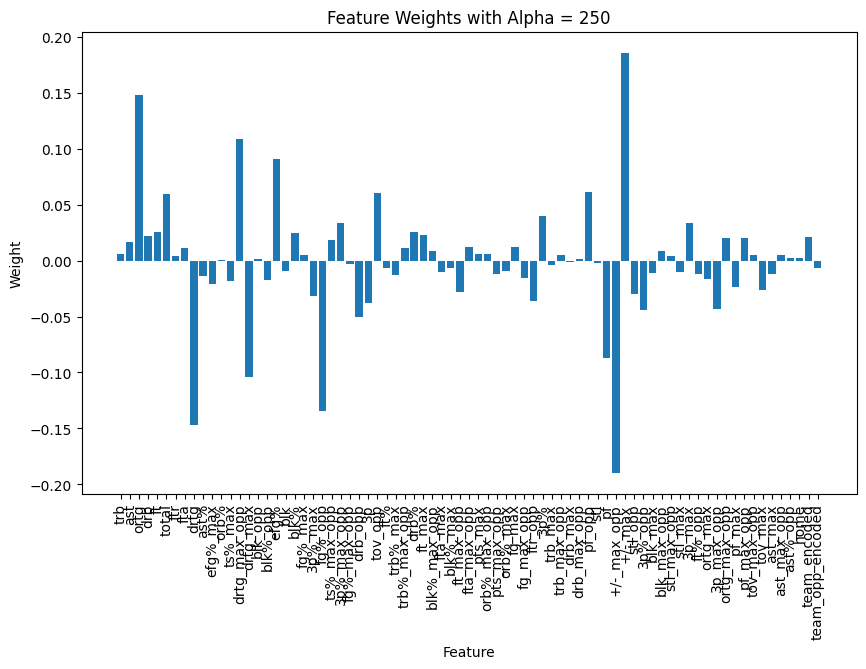

Top 50 important features:
+/-_max_opp: -0.1896
+/-_max: 0.1858
ortg: 0.1479
drtg: -0.1473
fg%_opp: -0.1343
drtg_max_opp: 0.1083
drtg_max: -0.1038
efg%: 0.0910
pf: -0.0875
pf_opp: 0.0611
tov_opp: 0.0607
total: 0.0591
drb_opp: -0.0500
3p%_opp: -0.0442
3p_max_opp: -0.0428
3p%: 0.0400
3p: -0.0375
ftr_opp: -0.0362
3p_max: 0.0337
3p%_max_opp: 0.0334
3p%_max: -0.0315
stl_opp: -0.0301
ft_max_opp: -0.0279
tov_max: -0.0260
ft: 0.0256
drb%: 0.0256
blk%: 0.0244
pf_max: -0.0236
ft_max: 0.0233
drb: 0.0220
team_encoded: 0.0213
efg%_max: -0.0209
pf_max_opp: 0.0205
ortg_max_opp: 0.0199
ts%_max: -0.0186
ts%_max_opp: 0.0184
blk%_opp: -0.0173
ast: 0.0170
ortg_max: -0.0166
fg_max_opp: -0.0155
ast%: -0.0137
trb%_max: -0.0126
fta_max_opp: 0.0122
ft%_opp: -0.0122
fg_max: 0.0122
pts_max_opp: -0.0119
ast_max: -0.0118
trb%_max_opp: 0.0115
fta: 0.0114
blk_max: -0.0113


In [35]:
train_y = candidate['won']
train_x = candidate.drop(columns=['won'])

model = RidgeClassifier()

# 하이퍼파라미터 그리드 설정
param_grid = {'alpha': [0.01, 0.05, 0.1, 0.5, 1, 5, 10, 20, 25, 50, 75, 100, 200, 250, 500, 750, 1000]}

# 그리드 서치 수행
grid_search = GridSearchCV(model, param_grid, cv=tscv)
grid_search.fit(train_x, train_y)

# 최적의 모델 및 파라미터 출력
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

# 최적의 alpha 값을 사용하여 모델 학습
best_alpha = grid_search.best_params_['alpha']
best_model = RidgeClassifier(alpha=best_alpha)
best_model.fit(train_x, train_y)

# 피처 이름
feature_names = train_x.columns  # x가 DataFrame인 경우, 피처 이름을 가져옴

class_labels = best_model.classes_
print("Class labels:", class_labels)

# 피처 가중치 추출
feature_weights = best_model.coef_[0]

# 피처 가중치 시각화
plt.figure(figsize=(10, 6))
plt.bar(range(len(feature_weights)), feature_weights)
plt.xticks(range(len(feature_weights)), feature_names, rotation=90)
plt.xlabel('Feature')
plt.ylabel('Weight')
plt.title(f'Feature Weights with Alpha = {best_alpha}')
plt.show()

# 중요한 피처 선택
important_features = np.argsort(np.abs(feature_weights))[::-1]  # 절대값 기준으로 정렬

# 중요한 피처 출력
print("Top 50 important features:")
for i in range(50):
    print(f"{feature_names[important_features[i]]}: {feature_weights[important_features[i]]:.4f}")

top_50_features = feature_names[important_features[:50]].tolist()
label_column = ['won']

In [36]:
train_X = train_x[top_50_features]
valid_X = val_folds[0][top_50_features]
test_X = tss_test[top_50_features]

train_Y = train_y
valid_Y = val_folds[0][label_column]
test_Y = tss_test[label_column]

,+/-_max_opp,+/-_max,ortg,drtg,fg%_opp,drtg_max_opp,drtg_max,efg%,pf,pf_opp,...,ast%,trb%_max,fta_max_opp,ft%_opp,fg_max,pts_max_opp,ast_max,trb%_max_opp,fta,blk_max
0,1.272727,-0.181818,-0.773780,0.360898,-1.257667,-0.785714,0.428571,-0.040293,1.102093,-1.224930,...,0.178252,0.193717,0.75,0.066573,-0.333333,-0.375,-1.000000,0.374346,-1.120148,0.5
1,-0.181818,1.272727,0.365588,-0.781159,-0.023858,0.428571,-0.785714,-0.874909,-1.223414,1.106864,...,0.444307,0.374346,-0.75,0.366158,-0.666667,-0.500,-0.666667,0.193717,0.386843,0.0
2,-0.272727,-0.272727,-0.873249,-1.062142,-0.902479,-0.714286,-0.785714,-0.586004,0.404441,0.174147,...,-2.226095,0.405759,-0.75,-1.682613,-0.333333,0.125,-0.666667,0.348168,-0.024154,2.0
3,-0.272727,-0.272727,-1.054101,-0.880863,-0.509904,-0.785714,-0.714286,-0.810708,0.171890,0.407326,...,1.055247,0.348168,-0.50,-0.638900,1.000000,-0.625,0.000000,0.405759,-0.846150,0.0
4,0.363636,1.636364,0.808675,-0.563624,-0.622068,0.642857,-0.285714,2.014148,0.869542,-0.525392,...,-0.994360,0.230366,0.00,0.230862,0.000000,0.250,-0.333333,0.235602,-0.435152,-0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2207,0.181818,-0.818182,-1.605699,-0.781159,-1.594160,-1.214286,-0.428571,-1.372469,-1.455965,-0.991750,...,-2.068433,0.154450,-0.25,1.090959,-0.666667,-0.500,-1.333333,0.170157,-1.257148,0.5
2208,1.727273,-0.545455,-2.437619,-0.164811,-0.939868,-1.571429,0.071429,-2.110784,-0.060661,-0.525392,...,1.350864,0.460733,-0.25,-2.301110,-1.333333,-0.125,0.666667,0.403141,-1.394147,1.0
2209,0.727273,0.636364,0.980485,1.647979,1.695998,0.785714,1.285714,0.714072,-0.060661,0.174147,...,-0.156780,0.445026,-0.25,1.226255,-0.333333,-0.125,1.333333,0.188482,-0.435152,-0.5
2210,0.636364,0.727273,1.649637,0.977247,0.462188,1.285714,0.785714,2.142551,0.171890,-0.059033,...,0.138836,0.188482,0.25,1.332559,-0.333333,0.375,1.333333,0.445026,-0.709151,-0.5


In [37]:
# 필요한 라이브러리 임포트
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import GridSearchCV

# 모델들과 그리드 서치를 위한 파라미터 그리드 설정
models = [
    ('Logistic Regression', LogisticRegression(max_iter=10000), {
        'C': [0.1, 1, 10, 100],
        'solver': ['liblinear', 'lbfgs']
    }),
    ('Decision Tree', DecisionTreeClassifier(), {
        'criterion': ['gini', 'entropy'],
        'max_depth': [None, 10, 20, 30, 40, 50]
    }),
    ('Random Forest', RandomForestClassifier(), {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 10, 20, 30, 40, 50]
    }),
    ('SVM', SVC(), {
        'C': [0.1, 1, 10, 100],
        'kernel': ['linear', 'rbf']
    }),
    ('Gradient Boosting', GradientBoostingClassifier(), {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 4, 5]
    }),
    ('XGBoost', xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss'), {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 4, 5]
    })
]

# 결과 저장용 리스트
results = []

# 각 모델에 대해 학습 및 평가
for name, model, params in models:
    grid_search = GridSearchCV(model, params, cv=5, scoring='f1')
    grid_search.fit(train_X, train_Y.values.ravel())
    
    best_model = grid_search.best_estimator_
    predictions = best_model.predict(valid_X)

    accuracy = accuracy_score(valid_Y, predictions)
    precision = precision_score(valid_Y, predictions)
    recall = recall_score(valid_Y, predictions)
    f1 = f1_score(valid_Y, predictions)

    results.append((name, accuracy, precision, recall, f1, grid_search.best_params_))

    print(f"Model: {name}")
    print(f"Best Parameters: {grid_search.best_params_}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("-" * 30)
    print(classification_report(valid_Y, predictions))


Model: Logistic Regression
Best Parameters: {'C': 10, 'solver': 'liblinear'}
Accuracy: 0.9977
Precision: 0.9982
Recall: 0.9973
F1 Score: 0.9977
------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1104
           1       1.00      1.00      1.00      1105

    accuracy                           1.00      2209
   macro avg       1.00      1.00      1.00      2209
weighted avg       1.00      1.00      1.00      2209

Model: Decision Tree
Best Parameters: {'criterion': 'entropy', 'max_depth': 20}
Accuracy: 0.9013
Precision: 0.8921
Recall: 0.9131
F1 Score: 0.9025
------------------------------
              precision    recall  f1-score   support

           0       0.91      0.89      0.90      1104
           1       0.89      0.91      0.90      1105

    accuracy                           0.90      2209
   macro avg       0.90      0.90      0.90      2209
weighted avg       0.90      0.90      0.90     

Traceback (most recent call last):
  File "C:\Users\문창원\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py", line 3508, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\문창원\AppData\Local\Temp\ipykernel_8052\1394161836.py", line 46, in <module>
    grid_search.fit(train_X, train_Y.values.ravel())
  File "C:\Users\문창원\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Users\문창원\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_search.py", line 970, in fit
    self._run_search(evaluate_candidates)
  File "C:\Users\문창원\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_search.py", line 1527, in _run_search
    evaluate_candidates(ParameterGrid(self.param_grid))
  File "C:\Users\문창원\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\

In [38]:
# 필요한 라이브러리 임포트
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# 모델들을 리스트에 저장
models = [
    ('Logistic Regression', LogisticRegression(max_iter=10000)),
    ('Decision Tree', DecisionTreeClassifier()),
    ('Random Forest', RandomForestClassifier()),
    ('SVM', SVC()),
    ('Gradient Boosting', GradientBoostingClassifier()),
    ('XGBoost', xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss'))
]

# 결과 저장용 리스트
results = []

# 각 모델에 대해 학습 및 평가
for name, model in models:
    model.fit(train_X, train_Y.values.ravel())
    predictions = model.predict(valid_X)

    accuracy = accuracy_score(valid_Y, predictions)
    precision = precision_score(valid_Y, predictions)
    recall = recall_score(valid_Y, predictions)
    f1 = f1_score(valid_Y, predictions)

    results.append((name, accuracy, precision, recall, f1))

    print(f"Model: {name}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("-" * 30)
    print(classification_report(valid_Y, predictions))


Model: Logistic Regression
Accuracy: 0.9900
Precision: 0.9874
Recall: 0.9928
F1 Score: 0.9901
------------------------------
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1104
           1       0.99      0.99      0.99      1105

    accuracy                           0.99      2209
   macro avg       0.99      0.99      0.99      2209
weighted avg       0.99      0.99      0.99      2209

Model: Decision Tree
Accuracy: 0.8895
Precision: 0.8875
Recall: 0.8923
F1 Score: 0.8899
------------------------------
              precision    recall  f1-score   support

           0       0.89      0.89      0.89      1104
           1       0.89      0.89      0.89      1105

    accuracy                           0.89      2209
   macro avg       0.89      0.89      0.89      2209
weighted avg       0.89      0.89      0.89      2209

Model: Random Forest
Accuracy: 0.9665
Precision: 0.9648
Recall: 0.9683
F1 Score: 0.9666
--------------

In [40]:
# 필요한 라이브러리 임포트
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import GridSearchCV

# 모델들과 그리드 서치를 위한 파라미터 그리드 설정
models = [
    ('Logistic Regression', LogisticRegression(max_iter=10000), {
        'C': [0.1, 1, 10, 100],
        'solver': ['liblinear', 'lbfgs']
    }),
    ('Decision Tree', DecisionTreeClassifier(), {
        'criterion': ['gini', 'entropy'],
        'max_depth': [None, 10, 20, 30, 40, 50]
    }),
    ('Random Forest', RandomForestClassifier(), {
        'n_estimators': [100, 200, 300,400,500],
        'max_depth': [None, 10, 20, 30, 40, 50,60,70]
    }),
    ('XGBoost', xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss'), {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 4, 5]
    })
]

# 결과 저장용 리스트
results = []

# 각 모델에 대해 학습 및 평가
for name, model, params in models:
    grid_search = GridSearchCV(model, params, cv=5, scoring='f1')
    grid_search.fit(train_X, train_Y.values.ravel())
    
    best_model = grid_search.best_estimator_
    predictions = best_model.predict(test_X)

    accuracy = accuracy_score(test_Y, predictions)
    precision = precision_score(test_Y, predictions)
    recall = recall_score(test_Y, predictions)
    f1 = f1_score(test_Y, predictions)

    results.append((name, accuracy, precision, recall, f1, grid_search.best_params_))

    print(f"Model: {name}")
    print(f"Best Parameters: {grid_search.best_params_}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("-" * 30)
    print(classification_report(test_Y, predictions))


Model: Logistic Regression
Best Parameters: {'C': 10, 'solver': 'liblinear'}
Accuracy: 0.7333
Precision: 0.7062
Recall: 0.7983
F1 Score: 0.7494
------------------------------
              precision    recall  f1-score   support

           0       0.77      0.67      0.71       844
           1       0.71      0.80      0.75       843

    accuracy                           0.73      1687
   macro avg       0.74      0.73      0.73      1687
weighted avg       0.74      0.73      0.73      1687

Model: Decision Tree
Best Parameters: {'criterion': 'entropy', 'max_depth': 50}
Accuracy: 0.6817
Precision: 0.6674
Recall: 0.7236
F1 Score: 0.6944
------------------------------
              precision    recall  f1-score   support

           0       0.70      0.64      0.67       844
           1       0.67      0.72      0.69       843

    accuracy                           0.68      1687
   macro avg       0.68      0.68      0.68      1687
weighted avg       0.68      0.68      0.68     

In [58]:
# 필요한 라이브러리 임포트
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import GridSearchCV
import numpy as np

# 모델들과 그리드 서치를 위한 파라미터 그리드 설정
models = [
    ('Logistic Regression', LogisticRegression(max_iter=10000), {
        'C': [0.1, 1, 10, 100],
        'solver': ['liblinear', 'lbfgs']
    }),
    ('Decision Tree', DecisionTreeClassifier(), {
        'criterion': ['gini', 'entropy'],
        'max_depth': [None, 10, 20, 30, 40, 50]
    }),
    ('Random Forest', RandomForestClassifier(), {
        'n_estimators': [100, 200, 300,400,500],
        'max_depth': [None, 10, 20, 30, 40, 50,60,70]
    }),
    ('XGBoost', xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss'), {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 4, 5]
    })
]

# 결과 저장용 딕셔너리
results = {model[0]: {'accuracy': [], 'precision': [], 'recall': [], 'f1': []} for model in models}

# 각 폴드에 대해 학습 및 평가
for fold_idx in range(len(val_folds)):
    train_X = train_folds[fold_idx][top_50_features]
    valid_X = val_folds[fold_idx][top_50_features]
    test_X = tss_test[top_50_features]
    
    candidate = train_folds[fold_idx]
    train_y = candidate['won']

    train_Y = train_y
    valid_Y = val_folds[fold_idx][label_column]
    test_Y = tss_test[label_column]
    
    print(f"Fold {fold_idx + 1} 결과")
    print("=" * 50)

    # 각 모델에 대해 학습 및 평가
    for name, model, params in models:
        grid_search = GridSearchCV(model, params, cv=5, scoring='f1')
        grid_search.fit(train_X, train_Y.values.ravel())

        best_model = grid_search.best_estimator_
        predictions = 
        best_model.predict(test_X)

        accuracy = accuracy_score(test_Y, predictions)
        precision = precision_score(test_Y, predictions)
        recall = recall_score(test_Y, predictions)
        f1 = f1_score(test_Y, predictions)

        results[name]['accuracy'].append(accuracy)
        results[name]['precision'].append(precision)
        results[name]['recall'].append(recall)
        results[name]['f1'].append(f1)

        print(f"Model: {name}")
        print(f"Best Parameters: {grid_search.best_params_}")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1 Score: {f1:.4f}")
        print("-" * 30)
        print(classification_report(test_Y, predictions))
        print("=" * 50)

# 각 모델에 대한 평균 결과 계산 및 출력
print("평균 결과")
print("=" * 50)
for name in results:
    avg_accuracy = np.mean(results[name]['accuracy'])
    avg_precision = np.mean(results[name]['precision'])
    avg_recall = np.mean(results[name]['recall'])
    avg_f1 = np.mean(results[name]['f1'])

    print(f"Model: {name}")
    print(f"Average Accuracy: {avg_accuracy:.4f}")
    print(f"Average Precision: {avg_precision:.4f}")
    print(f"Average Recall: {avg_recall:.4f}")
    print(f"Average F1 Score: {avg_f1:.4f}")
    print("-" * 50)


Fold 1 결과
Model: Logistic Regression
Best Parameters: {'C': 10, 'solver': 'liblinear'}
Accuracy: 0.7333
Precision: 0.7062
Recall: 0.7983
F1 Score: 0.7494
------------------------------
              precision    recall  f1-score   support

           0       0.77      0.67      0.71       844
           1       0.71      0.80      0.75       843

    accuracy                           0.73      1687
   macro avg       0.74      0.73      0.73      1687
weighted avg       0.74      0.73      0.73      1687

Model: Decision Tree
Best Parameters: {'criterion': 'entropy', 'max_depth': None}
Accuracy: 0.6817
Precision: 0.6674
Recall: 0.7236
F1 Score: 0.6944
------------------------------
              precision    recall  f1-score   support

           0       0.70      0.64      0.67       844
           1       0.67      0.72      0.69       843

    accuracy                           0.68      1687
   macro avg       0.68      0.68      0.68      1687
weighted avg       0.68      0.68   

C:\Users\문창원\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\문창원\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\문창원\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{met

Model: Decision Tree
Best Parameters: {'criterion': 'entropy', 'max_depth': None}
Accuracy: 0.5003
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
------------------------------
              precision    recall  f1-score   support

           0       0.50      1.00      0.67       844
           1       0.00      0.00      0.00       843

    accuracy                           0.50      1687
   macro avg       0.25      0.50      0.33      1687
weighted avg       0.25      0.50      0.33      1687

Model: Random Forest
Best Parameters: {'max_depth': 50, 'n_estimators': 500}
Accuracy: 0.6870
Precision: 0.6918
Recall: 0.6738
F1 Score: 0.6827
------------------------------
              precision    recall  f1-score   support

           0       0.68      0.70      0.69       844
           1       0.69      0.67      0.68       843

    accuracy                           0.69      1687
   macro avg       0.69      0.69      0.69      1687
weighted avg       0.69      0.69      0.69   

Logistic Regression 모델 SHAP 해석


100%|===================| 10994/11048 [00:37<00:00]        

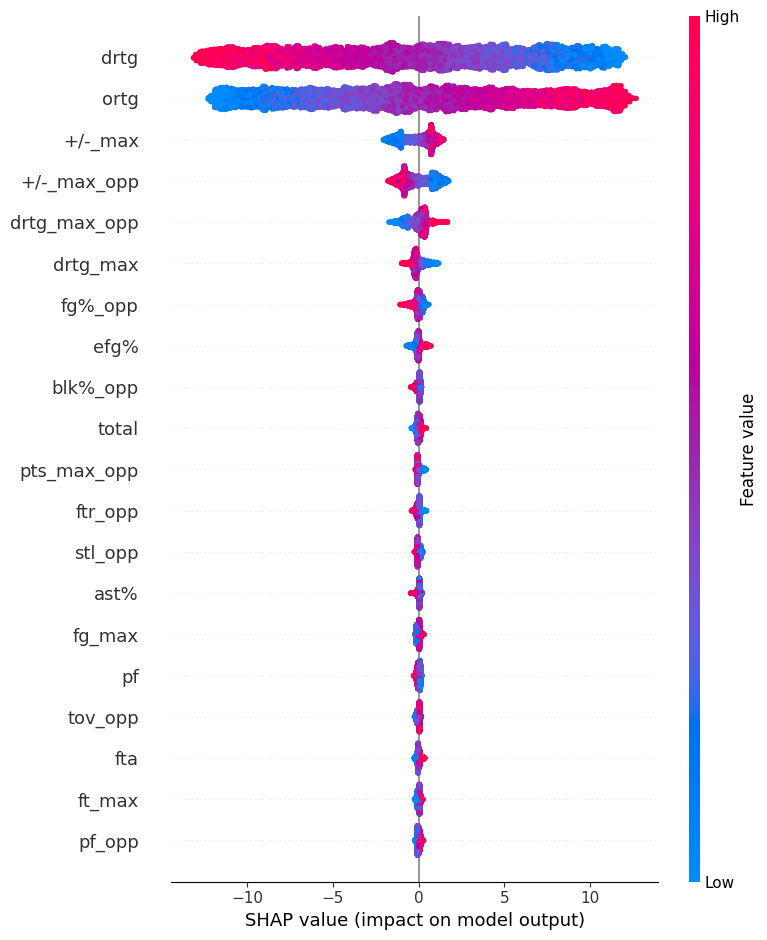

Decision Tree 모델 자체 해석


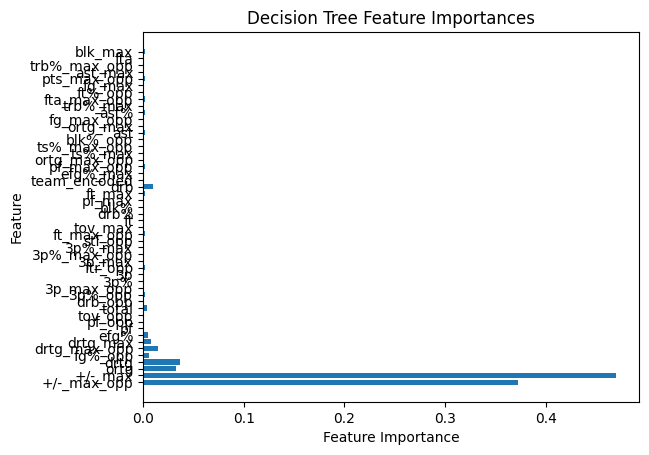

Random Forest 모델 피처 중요도 해석


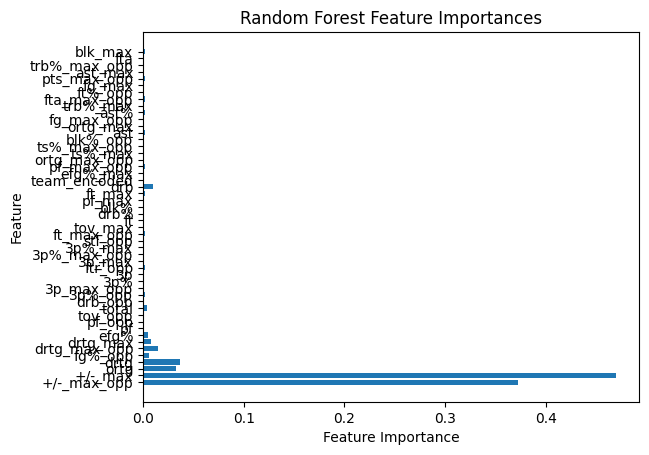

XGBoost 모델 SHAP 해석


 99%|===================| 10984/11048 [00:36<00:00]        

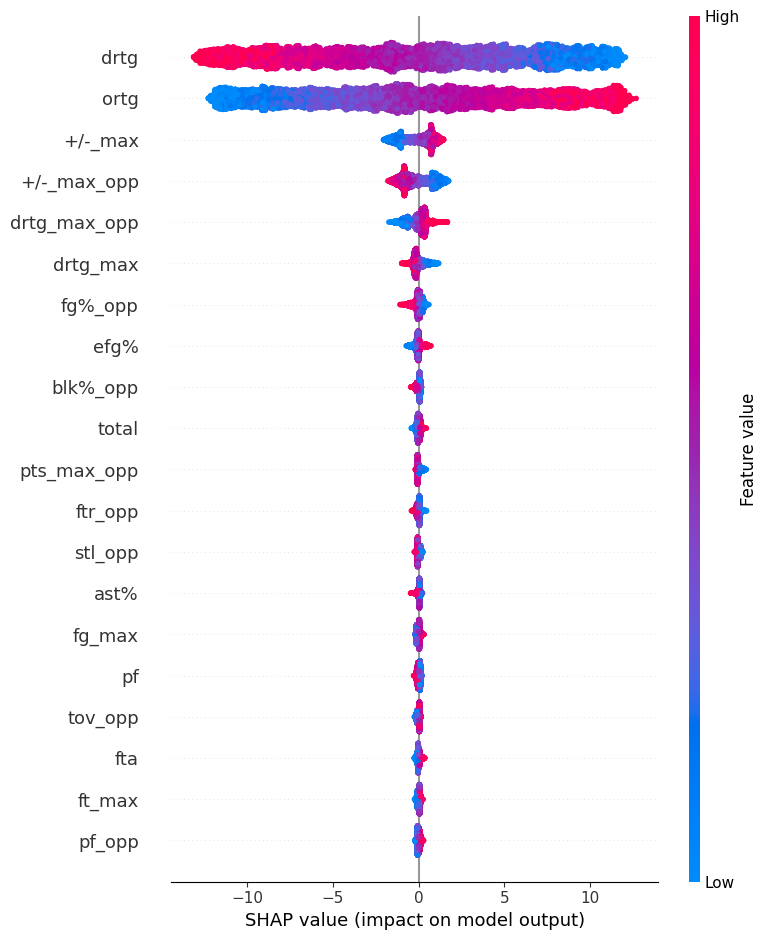

In [63]:
import shap
import lime
import lime.lime_tabular
import matplotlib.pyplot as plt

# SHAP 해석 함수 (Logistic Regression, Gradient Boosting, XGBoost)
def shap_interpretation(model, data):
    explainer = shap.Explainer(model, data)
    shap_values = explainer(data)
    shap.summary_plot(shap_values, data)


# 모델별 해석
for name, model, params in models:
    # 그리드 서치 및 모델 학습

    # 모델 해석
    if name == 'Logistic Regression' or name == 'Gradient Boosting' or name == 'XGBoost':
        print(f"{name} 모델 SHAP 해석")
        shap_interpretation(best_model, train_X)
    elif name == 'Decision Tree':
        print(f"{name} 모델 자체 해석")
        # 트리 모델의 경우, 자체 해석이 가능
        feature_importances = best_model.feature_importances_
        plt.barh(train_X.columns, feature_importances)
        plt.xlabel('Feature Importance')
        plt.ylabel('Feature')
        plt.title(f'{name} Feature Importances')
        plt.show()
    elif name == 'Random Forest':
        print(f"{name} 모델 피처 중요도 해석")
        feature_importances = best_model.feature_importances_
        plt.barh(train_X.columns, feature_importances)
        plt.xlabel('Feature Importance')
        plt.ylabel('Feature')
        plt.title(f'{name} Feature Importances')
        plt.show()
    elif name == 'SVM':
        print(f"{name} 모델 LIME 해석")
        lime_interpretation(best_model, train_X, test_X, train_X.columns)


Logistic Regression 모델 SHAP 해석


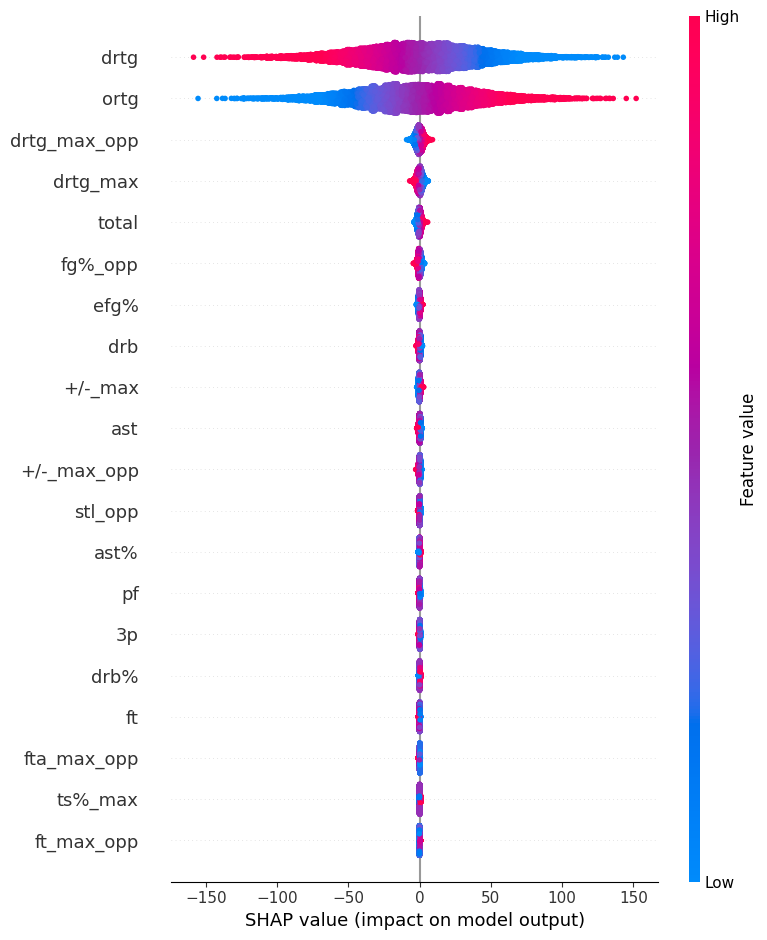

Decision Tree 모델 자체 해석


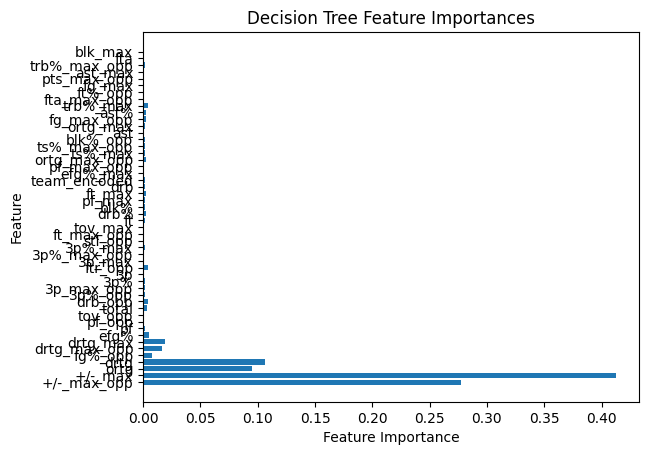

KeyboardInterrupt: 

In [64]:
import shap
import lime
import lime.lime_tabular
import matplotlib.pyplot as plt

# SHAP 해석 함수 (Logistic Regression, Gradient Boosting, XGBoost)
def shap_interpretation(model, data):
    explainer = shap.Explainer(model, data)
    shap_values = explainer(data)
    shap.summary_plot(shap_values, data)


# 모델별 해석
for name, model, params in models:
    # 그리드 서치 및 모델 학습
    grid_search = GridSearchCV(model, params, cv=5, scoring='f1')
    grid_search.fit(train_X, train_Y.values.ravel())
    best_model = grid_search.best_estimator_

    # 모델 해석
    if name == 'Logistic Regression' or name == 'Gradient Boosting' or name == 'XGBoost':
        print(f"{name} 모델 SHAP 해석")
        shap_interpretation(best_model, train_X)
    elif name == 'Decision Tree':
        print(f"{name} 모델 자체 해석")
        # 트리 모델의 경우, 자체 해석이 가능
        feature_importances = best_model.feature_importances_
        plt.barh(train_X.columns, feature_importances)
        plt.xlabel('Feature Importance')
        plt.ylabel('Feature')
        plt.title(f'{name} Feature Importances')
        plt.show()
    elif name == 'Random Forest':
        print(f"{name} 모델 피처 중요도 해석")
        feature_importances = best_model.feature_importances_
        plt.barh(train_X.columns, feature_importances)
        plt.xlabel('Feature Importance')
        plt.ylabel('Feature')
        plt.title(f'{name} Feature Importances')
        plt.show()
    elif name == 'SVM':
        print(f"{name} 모델 LIME 해석")
        lime_interpretation(best_model, train_X, test_X, train_X.columns)


In [65]:
# 필요한 라이브러리 임포트
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import GridSearchCV
import numpy as np

# 모델들과 그리드 서치를 위한 파라미터 그리드 설정
models = [
    ('SVM', SVC(), {
        'C': [0.1, 1, 10, 100],
        'kernel': ['linear', 'rbf']
    })
]

# 결과 저장용 딕셔너리
results = {model[0]: {'accuracy': [], 'precision': [], 'recall': [], 'f1': []} for model in models}

# 각 폴드에 대해 학습 및 평가
for fold_idx in range(len(val_folds)):
    train_X = train_folds[fold_idx][top_50_features]
    valid_X = val_folds[fold_idx][top_50_features]
    test_X = tss_test[top_50_features]

    candidate = train_folds[fold_idx]
    train_y = candidate['won']

    train_Y = train_y
    valid_Y = val_folds[fold_idx][label_column]
    test_Y = tss_test[label_column]

    print(f"Fold {fold_idx + 1} 결과")
    print("=" * 50)

    # 각 모델에 대해 학습 및 평가
    for name, model, params in models:
        grid_search = GridSearchCV(model, params, cv=5, scoring='f1')
        grid_search.fit(train_X, train_Y.values.ravel())

        best_model = grid_search.best_estimator_
        best_model.predict(test_X)

        accuracy = accuracy_score(test_Y, predictions)
        precision = precision_score(test_Y, predictions)
        recall = recall_score(test_Y, predictions)
        f1 = f1_score(test_Y, predictions)

        results[name]['accuracy'].append(accuracy)
        results[name]['precision'].append(precision)
        results[name]['recall'].append(recall)
        results[name]['f1'].append(f1)

        print(f"Model: {name}")
        print(f"Best Parameters: {grid_search.best_params_}")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1 Score: {f1:.4f}")
        print("-" * 30)
        print(classification_report(test_Y, predictions))
        print("=" * 50)

# 각 모델에 대한 평균 결과 계산 및 출력
print("평균 결과")
print("=" * 50)
for name in results:
    avg_accuracy = np.mean(results[name]['accuracy'])
    avg_precision = np.mean(results[name]['precision'])
    avg_recall = np.mean(results[name]['recall'])
    avg_f1 = np.mean(results[name]['f1'])

    print(f"Model: {name}")
    print(f"Average Accuracy: {avg_accuracy:.4f}")
    print(f"Average Precision: {avg_precision:.4f}")
    print(f"Average Recall: {avg_recall:.4f}")
    print(f"Average F1 Score: {avg_f1:.4f}")
    print("-" * 50)


Fold 1 결과
Model: SVM
Best Parameters: {'C': 1, 'kernel': 'linear'}
Accuracy: 0.6846
Precision: 0.6290
Recall: 0.8992
F1 Score: 0.7402
------------------------------
              precision    recall  f1-score   support

           0       0.82      0.47      0.60       844
           1       0.63      0.90      0.74       843

    accuracy                           0.68      1687
   macro avg       0.73      0.68      0.67      1687
weighted avg       0.73      0.68      0.67      1687

Fold 2 결과
Model: SVM
Best Parameters: {'C': 10, 'kernel': 'linear'}
Accuracy: 0.6846
Precision: 0.6290
Recall: 0.8992
F1 Score: 0.7402
------------------------------
              precision    recall  f1-score   support

           0       0.82      0.47      0.60       844
           1       0.63      0.90      0.74       843

    accuracy                           0.68      1687
   macro avg       0.73      0.68      0.67      1687
weighted avg       0.73      0.68      0.67      1687

Fold 3 결과
Model